### Análise 2 - A teoria do achismo

A análise abaixo consistem na aplicação de técnicas baseadas no achismo não-ortodoxas a fim de criar um robô de trade. 

In [1]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)

import pandas as pd
from IPython.display import Image

Populating the interactive namespace from numpy and matplotlib


In [2]:
names = ['sell', 'buy', 'last', 'vol', 'high', 'low', 'date']

data = pd.read_csv('btc.csv', names=names, skiprows=1)

In [3]:
data.head()

,sell,buy,last,vol,high,low,date
0,23000.0,22900.0,23000.0,788.669923,23990.0,20600.0,1509541173
1,23000.0,22900.0,23000.0,788.467873,23990.0,20600.0,1509541173
2,23000.0,22900.0,23000.0,788.467873,23990.0,20600.0,1509541173
3,23000.0,22900.0,23000.0,788.679923,23990.0,20600.0,1509541173
4,23000.0,22900.0,23000.0,788.482139,23990.0,20600.0,1509541189


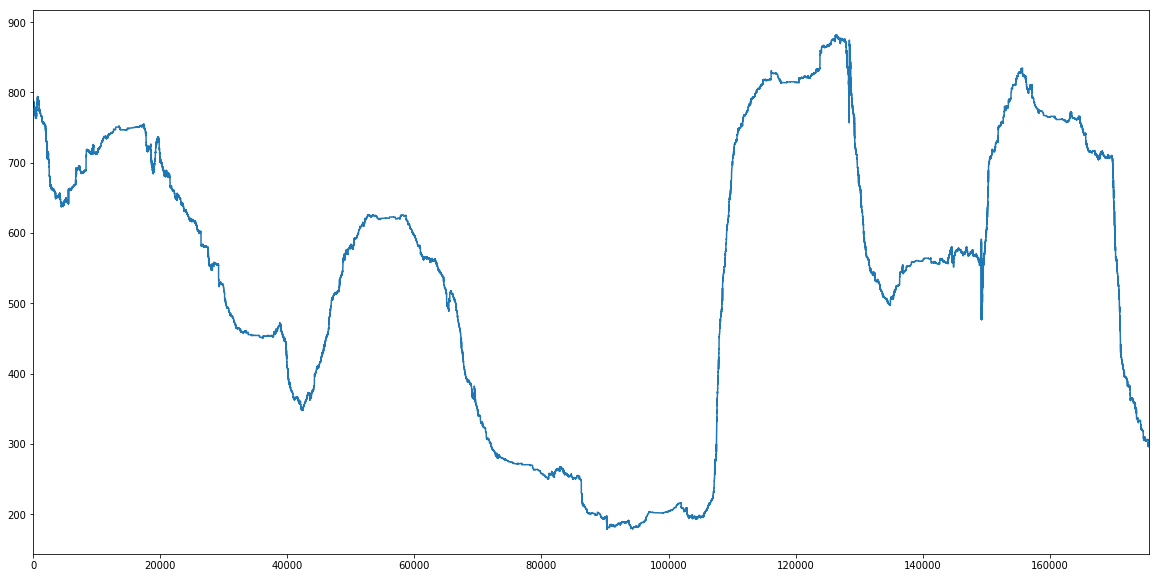

In [4]:
data['vol'].plot()

Acima é a representação do volume no período observado

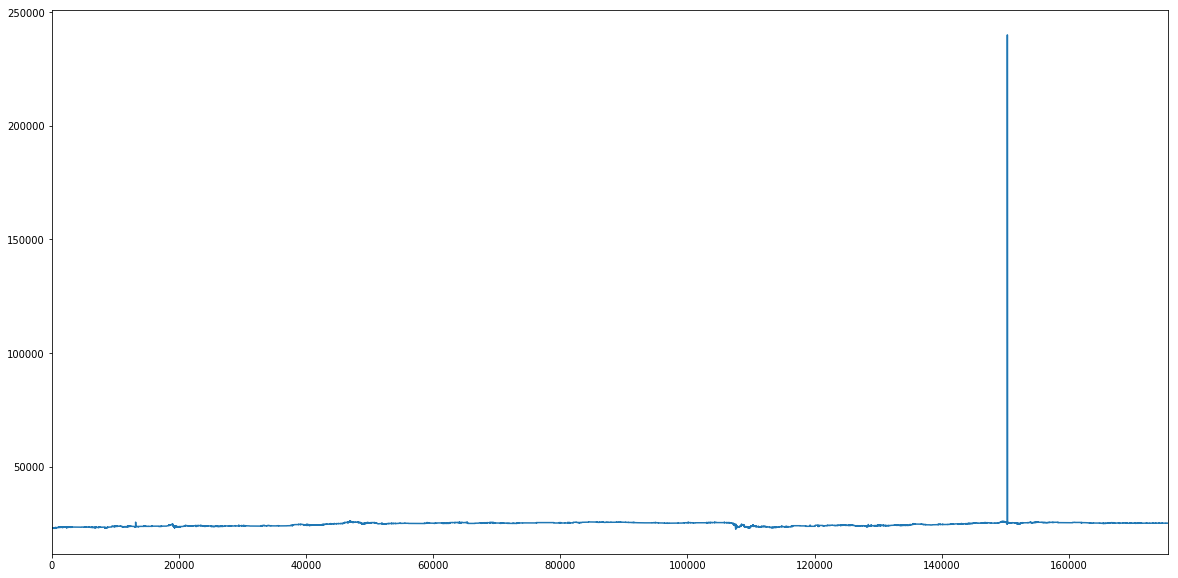

In [5]:
data['buy'].plot()

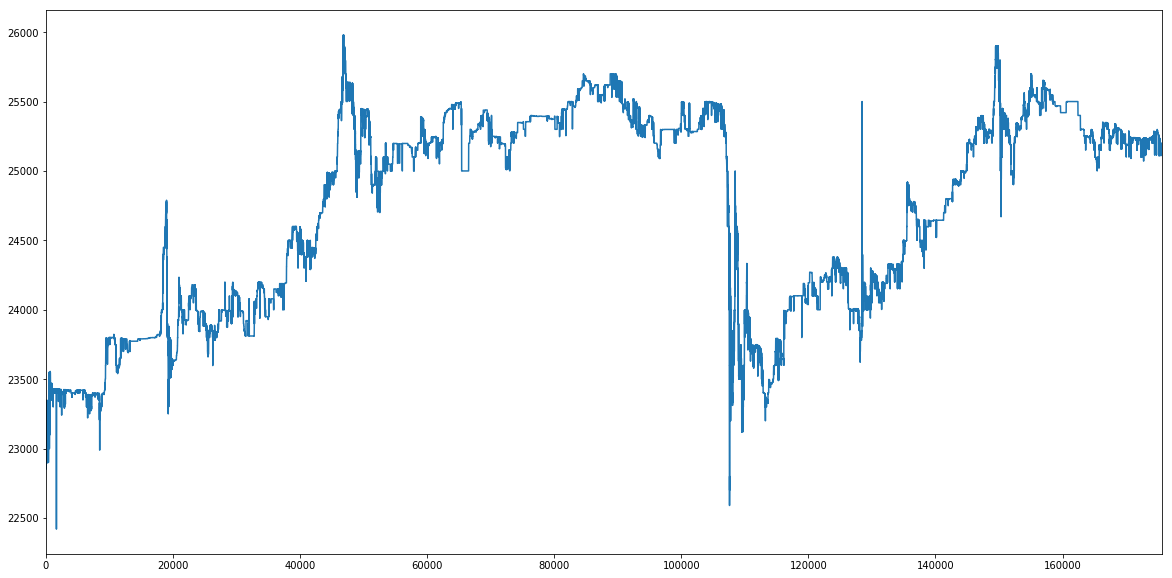

In [6]:
data['sell'].plot()

### Achismo 1
O modus operandi básico no mercado de ações é comprar na baixa e vender na alta. Para que essa regra seja satisfeita, algumas métricas de variação teriam que ser estabelecidas para que o **algoritmo soubesse quando existem períodos de estabilidade, aumento e queda nas ações.**

A regras estabelecida foi bem simples: os valores referente a cotação dos valores de vendas e compras serão calculados usando a seguinte fórmula:

``` math
 V = P(atual) - P(antigo)
 
 P = Preço
 V = Valor
```

Se o falor **atual for maior do que o antigo**, o valor será acima de zero, ou seja, haverá uma valorização no preço.

Se o valor **atual for menor do que o antigo**, o valor será abaixo de zero, consequentemente houve uma desvalorização. 

Quando o resultado é zero, houve um estabilidade no preço. 


In [7]:
array = data['sell'].as_matrix();

variation_sell = []
for index in range(0, len(array)):
    if index == len(array) - 1: 
        break
    variation_sell.append( array[index + 1] - array[index])

array = data['buy'].as_matrix();

variation_buy = []
for index in range(0, len(array)):
    if index == len(array) - 1: 
        break
    variation_buy.append( array[index + 1] - array[index])

In [8]:
data['variation_sell'] = pd.DataFrame(data=variation_sell)
data['variation_buy'] = pd.DataFrame(data=variation_buy)

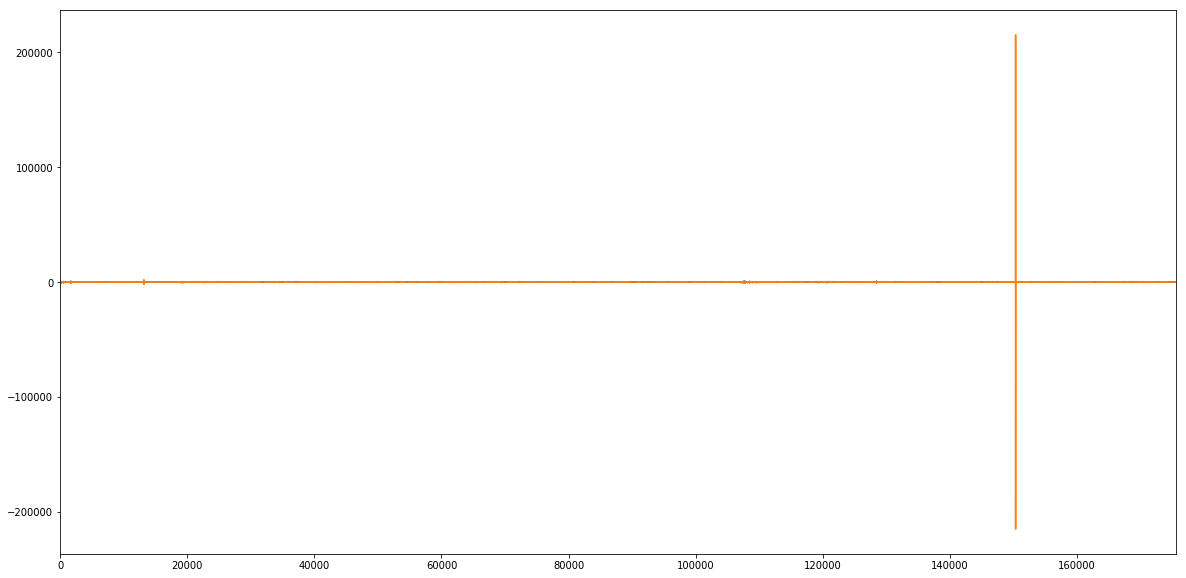

In [9]:
data['variation_sell'].plot()
data['variation_buy'].plot()

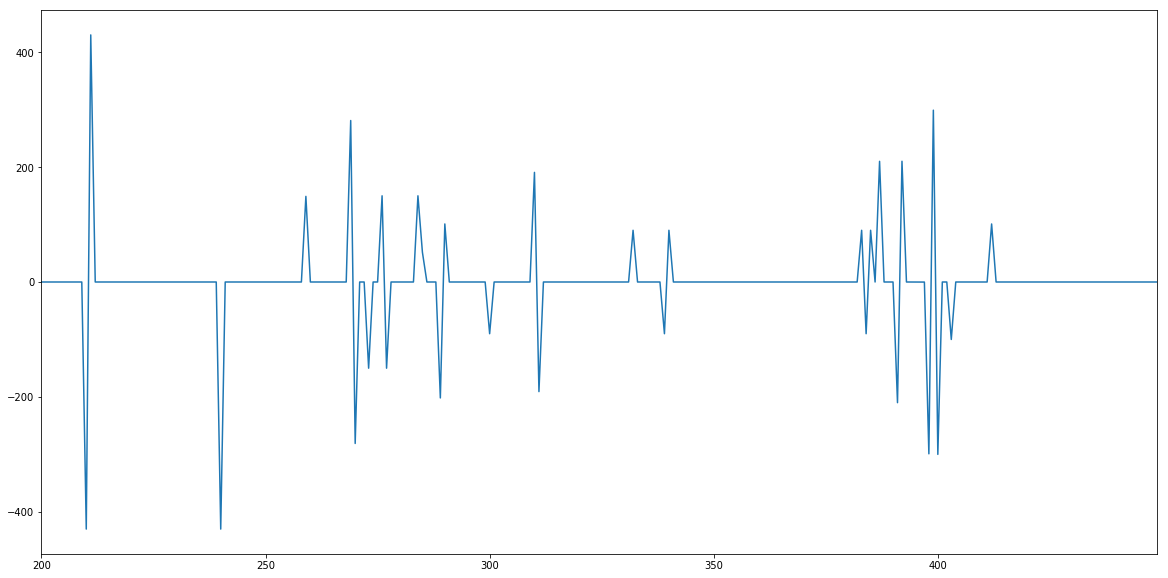

In [10]:
data['variation_sell'][200:450].plot()

Nota-se que em relação ao gráfico abaixo, o gráfico acima tem um comportamento "binário" de como as coisas estão acontecendo na realidade. 

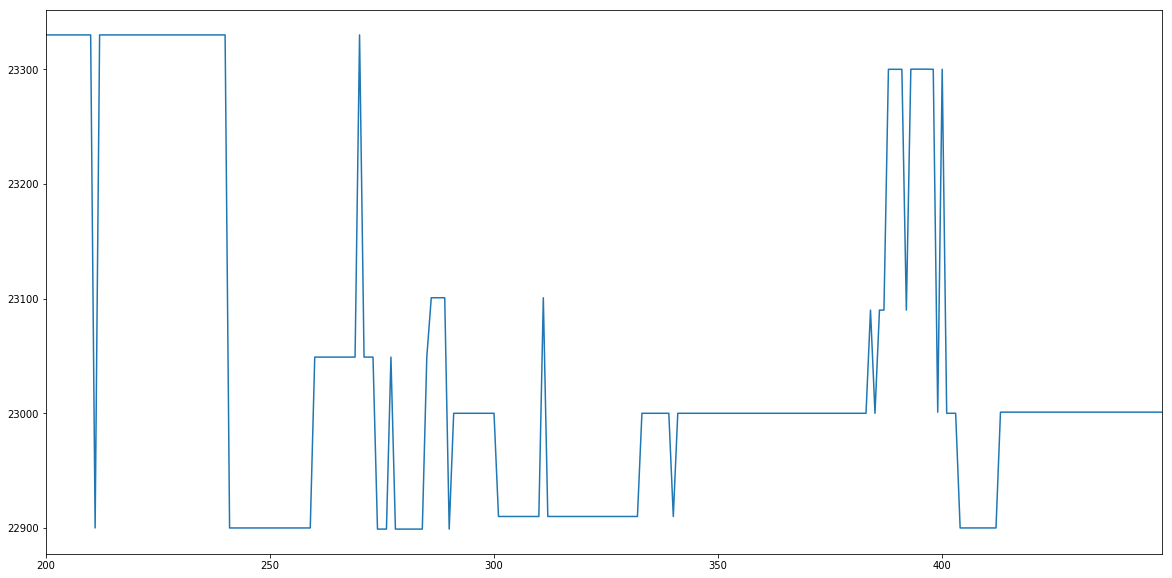

In [11]:
data['sell'][200:450].plot()

### Estabelecendo parâmetros que favoreçam a compra e venda
Ainda bebendo da fonte de "compre na baixa e venda na alta", algumas suposições podem ser feitas sobre os valores das variações.

No **caso da compra**, se a variação for menor do que zero, tal comportamento poeria indicar um momento favorável para compra.

No **caso da venda**, se a variação for maior do que zero, tal comportamento favorece a venda para obtenção de lucro. 

In [12]:
data['sell?'] = data['variation_sell'] > 0.0
data['buy?'] = data['variation_buy'] < 0.0

In [13]:
data.head(10)

,sell,buy,last,vol,high,low,date,variation_sell,variation_buy,sell?,buy?
0,23000.0,22900.0,23000.0,788.669923,23990.0,20600.0,1509541173,0.0,0.0,False,False
1,23000.0,22900.0,23000.0,788.467873,23990.0,20600.0,1509541173,0.0,0.0,False,False
2,23000.0,22900.0,23000.0,788.467873,23990.0,20600.0,1509541173,0.0,0.0,False,False
3,23000.0,22900.0,23000.0,788.679923,23990.0,20600.0,1509541173,0.0,0.0,False,False
4,23000.0,22900.0,23000.0,788.482139,23990.0,20600.0,1509541189,0.0,0.0,False,False
5,23000.0,22900.0,22900.0,788.477748,23990.0,20600.0,1509541195,0.0,0.0,False,False
6,23000.0,22900.0,23000.0,788.485538,23990.0,20600.0,1509541196,0.0,0.0,False,False
7,23000.0,22900.0,23000.0,788.485538,23990.0,20600.0,1509541196,0.0,0.0,False,False
8,23000.0,22900.0,23000.0,788.485538,23990.0,20600.0,1509541196,0.0,0.0,False,False
9,23000.0,22900.0,23000.0,788.485538,23990.0,20600.0,1509541196,0.0,0.0,False,False


### Stop Loss and Start Gain

O método da variação nos possibilita enxergar de maneira autônoma momentos que são favoráveis para compra e venda. O método da variação guarda contexto de apenas dois valores: o imediatamente anterior e o atual. Por esse motivo, trades apenas baseados nessa análise poderia cuminar num total fracasso.

#### Quando comprar?

Vamos supor um caso hipotético em que a variação nos diz que as últimas 5 cotações são favoráveis para compra, a série seria:
* 100
* 99
* 98
* 97
* 96

Comprar na última cotação não seria o mais sensato. Ou as ações se **estabilizariam por muito tempo** ou **cairiam ainda mais**. Seria interessante se o algoritmo armazenasse a referência do primeiro valor que aprensenta favorecimento de compra. O algoritmos tomaria a decisão de compra assim que o preço começasse a subir novamente. Por exemplo: 

* 100
* 99
* 98
* 97
* __96__
* 96
* 96
* 96
* __97__

Entre o valor 96 e 97 houve um período de estabilidade e um de valorização. Assim que esse cenário ocorrer, o algoritmo iria calcular se valeria a pena comprar essa ação, exemplo:

``` math
V1 = 100
V2 = 97

Profit = V1 - V2

Neste caso: 
Profit = 3

```
Nesse casou house 3 unidades de lucro. Portanto, poderia valer a pena.

#### Quando vender?
A venda poderia ser o processo inverso do explanado acima. A variação iria disparar uma flag de favorável a venda e o código iria esperar até que o valor comece a depreciar novamente. 

### Outras métricas

[link](https://www.tororadar.com.br/investimento/analise-tecnica/analise-tecnica-de-acoes)
[link](https://www.metatrader5.com/pt/terminal/help/indicators/trend_indicators/ma)